## Data Pre-Processing

In [1]:
import pandas
import re
# load the dataset
dataset = pandas.read_csv('C:/Users/JITENDRA GARG/Desktop/Final/frenchenglish-bilingual-pairs/fra.txt', delimiter = '\t',header=None)
dataset.head()

,0,1
0,Go.,Va !
1,Run!,Cours !
2,Run!,Courez !
3,Wow!,Ça alors !
4,Fire!,Au feu !


In [2]:
## Renaming the column    
dataset=dataset.rename(columns={0: "English", 1: "French"})

**Punctuation removal**

In [3]:
dataset["new_column_French"] = dataset['French'].str.replace('[^\w\s]','')
dataset["new_column_English"] = dataset['English'].str.replace('[^\w\s]','')

**Converting to Lowercase**

In [4]:
dataset['new_column_English'] = dataset['new_column_English'].str.lower() 

**Converting French terms into unidecode**

In [5]:
from unidecode import unidecode

def split_it(text):
    words= re.findall(r'\w+', text, re.U)
    ## French column converted into lowercase and unidecode
    cap_words = [unidecode(word).lower() for word in words]
    return cap_words

In [6]:
dataset['new_column_French1'] = dataset['new_column_French'].apply(lambda x: split_it(x))
dataset['new_column_French1'].head()

0           [va]
1        [cours]
2       [courez]
3    [ca, alors]
4      [au, feu]
Name: new_column_French1, dtype: object

In [7]:
seperator = ' '
dataset['new_column_French1']= dataset['new_column_French1'].apply(lambda x: seperator.join(x))
dataset['new_column_French1'].head() 

0          va
1       cours
2      courez
3    ca alors
4      au feu
Name: new_column_French1, dtype: object

**Removing extra columns**

In [8]:
dataset=dataset.drop(columns=['English', 'French','new_column_French'],axis=1)
dataset.head()

,new_column_English,new_column_French1
0,go,va
1,run,cours
2,run,courez
3,wow,ca alors
4,fire,au feu


**Removing Stop Words**

In [9]:
###### For English ######
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')
#print(stop)

In [10]:
dataset['new_column_English'] = dataset['new_column_English'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
#dataset.head(10)

In [11]:
###### For Fench ########
from nltk.corpus import stopwords
stop_french = stopwords.words('french')
#print(stop_french)

In [12]:
dataset['new_column_French1'] = dataset['new_column_French1'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_french]))
#dataset.head(10)

**Separating columns into separate text file***

In [13]:
for c in dataset.columns:
    dataset[c].to_csv(c + '.txt', index=False)

/home/dai/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


### Load the word-vector file and create a dictionary of words and their ID

In [5]:
import io
import numpy as np

In [6]:
def load_vec(emb_path, nmax=7000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        
        ## Creating dictionary 
        for i, line in enumerate(f):
            ### Separating word from word-vector file
            word, vect = line.rstrip().split(' ', 1)    
            ### Separating vector
            vect = np.fromstring(vect, sep=' ')
            #print((vect))
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            #print(vectors)
            word2id[word] = len(word2id)
            #print(len(word2id))
            #print(word2id[word])
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    
    ##Creating a stack of vectors of words
    embeddings = np.vstack(vectors)
    #print(type(embeddings))
    return embeddings, id2word, word2id

In [7]:
src_path = '/home/dai/Desktop/Projectnew/wiki.en.align.vec'
tgt_path = '/home/dai/Desktop/Projectnew/wiki.fr.align.vec'

# maximum number of word embeddings to load
nmax = 7000 

src_embeddings, src_id2word, src_word2id= load_vec(src_path, nmax)
tgt_embeddings, tgt_id2word, tgt_word2id= load_vec(tgt_path, nmax)



## Get the nearest neighbours

In [8]:
def get_nn(key,word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=1):
    #print("Nearest neighbors of \"%s\":" % word)
    #print(tgt_emb.shape)
    
    word2id = {v: k for k, v in src_id2word.items()}
    key=word
    if key in word2id.keys():
       
    
        word_emb = src_emb[word2id[word]]
    #print(word_emb.shape)
    
    ## Calculating distance between words
        scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    
    ## returns index of that score 
        k_best = scores.argsort()[-K:][::-1]  
    #print(k_best)
    
        for i, idx in enumerate(k_best):
        #print(tgt_id2word[idx])
            translate=tgt_id2word[idx]
            #print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))
            return translate
    #else:
      #  pass
    #return tgt_id2word[k_best]

In [9]:
# printing nearest neighbors in the target space (For a single word)
src_word = 'thanks'
key=src_word
get_nn(key,src_word, src_embeddings, src_id2word, tgt_embeddings, tgt_id2word, K=1)



'merci'

**passing input text file of source words to a function get_nn**

In [10]:
huge=[]
with open('/home/dai/Desktop/project/new_column_English.txt','r') as file:
    huge=file.read().split()
    a=set(huge)
    b=list(a)
    

In [11]:
dictionary={}
for word in b:
    src_word=word
    key=src_word
    dictionary[word]=get_nn(key,src_word, src_embeddings, src_id2word, tgt_embeddings, tgt_id2word, K=1)

In [39]:
print(dictionary)

{',': None, '.': None, 'the': 'la', '</s>': None, 'of': 'de', '-': None, 'in': 'dans', 'and': 'et', "'": None, ')': None, '(': None, 'to': 'à', 'a': 'une', 'is': 'est', 'was': 'fut', 'on': 'sur', 's': None, 'for': 'pour', 'as': 'comme', 'by': 'par', 'that': 'que', 'it': 'elle', 'with': 'avec', 'from': 'provenant', 'at': 'où', 'he': 'il', 'this': 'cette', 'be': 'être', 'i': None, 'an': 'une', 'utc': None, 'his': 'son', 'not': 'pas', '–': None, 'are': 'sont', 'or': 'ou', 'talk': 'discuter', 'which': 'qui', 'also': 'également', 'has': 'a', 'were': 'étaient', 'but': 'mais', 'have': 'aient', '#': None, 'one': 'deux', 'rd': None, 'new': 'nouvelle', 'first': 'première', 'page': 'page', 'no': 'ni', 'you': 'peux', 'they': 'ils', 'had': 'avait', 'article': 'article', 't': None, 'who': 'jeune', '?': None, 'all': 'tous', 'their': 'leurs', 'there': 'existe', 'been': 'été', 'made': 'faites', 'its': 'son', 'people': 'personnes', 'may': 'février', 'after': 'après', '%': None, 'other': 'autres', 'shoul

## Creating Output file from a Dictionary

In [12]:
import csv

with open('dictionary.csv', 'w', newline="") as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in dictionary.items():
        writer.writerow([key, value])

## Visualization

In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([src_embeddings, tgt_embeddings]))
#print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

In [32]:
import matplotlib.pyplot as plt

def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    #print("src_word2id:",src_word2id)
    #print("tgt_words:",tgt_word2id)
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        #print(Y)
        word_labels.append(sw)
        #print(word_labels)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        #print("Y:",Y)
        word_labels.append(tw)
        #print(word_labels)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    #print("Y:",Y)
    x_coords = Y[:, 1]
    #print(Y[:, 1])
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min()-0.2, x_coords.max()+0.2 )
    plt.ylim(y_coords.min()-0.2, y_coords.max()+0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()


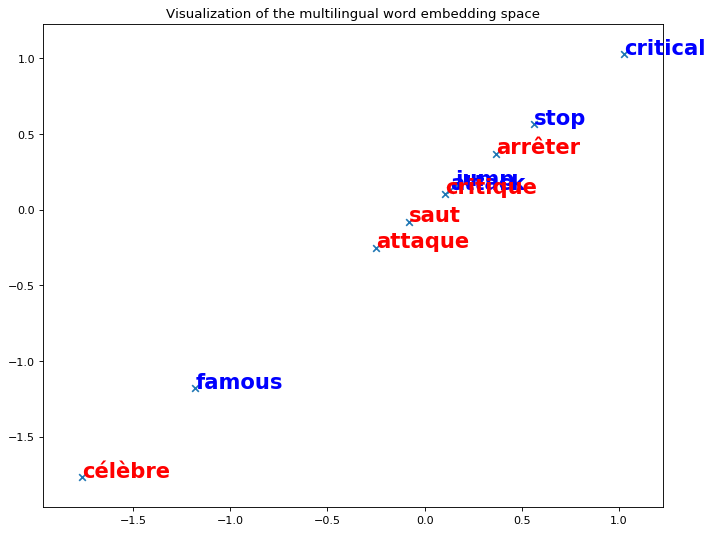

In [33]:
# get 5 random input words
src_words = ['stop', 'critical', 'jump', 'famous', 'attack']
tgt_words = ['arrêter', 'critique', 'saut',  'célèbre', 'attaque']

# assert words in dictionaries
#for sw in src_words:
   # assert sw in src_word2id, '"%s" not in source dictionary' % sw
#for tw in tgt_words:
   # assert tw in tgt_word2id, '"%s" not in target dictionary' % sw

plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words, tgt_word2id, tgt_embeddings, pca)
